# Data Science for Business - Exercise 3

# Cleaning the Data and Model Evaluation: Loan Default Case Study
---


### Name Last_Name

References:

1- Loan Default Dataset by M Yasser H: https://www.kaggle.com/datasets/yasserh/loan-default-dataset  Uploaded under CC0 licence.

2- Predicting Loan Defaults by Bayesian.Terrapin https://www.kaggle.com/code/bayesianterrapin/predicting-loan-defaults Shared under Apache 2.0 licence.

3- ROC and AUC by Akbar Huseynov https://www.kaggle.com/code/akbarhuseynov23/roc-and-auc Shared under Apache 2.0 licence.



In [42]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import pandas as pd

data = pd.read_csv('/content/drive/My Drive/Class_3.csv' )


In [44]:
data.head()

,ID,amount,Interest_rate_spread,loan_limit,loan_purpose,property_value,income,Gender,business_or_commercial,default
0,127451,266500,0.6664,cf,p3,518000.0,5760.0,Non-binary,nob/c,0
1,47873,456500,0.8255,cf,p1,478000.0,4920.0,Male,b/c,0
2,143258,216500,NaN,cf,no info,218000.0,NaN,Male,b/c,1
3,82415,856500,0.3007,ncf,p1,1108000.0,12360.0,Non-binary,nob/c,0
4,146580,116500,NaN,ncf,p3,NaN,4860.0,Male,nob/c,1


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      60000 non-null  int64  
 1   amount                  60000 non-null  int64  
 2   Interest_rate_spread    45208 non-null  float64
 3   loan_limit              58665 non-null  object 
 4   loan_purpose            59939 non-null  object 
 5   property_value          53856 non-null  float64
 6   income                  56279 non-null  float64
 7   Gender                  60000 non-null  object 
 8   business_or_commercial  60000 non-null  object 
 9   default                 60000 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 4.6+ MB


In [46]:
data.isnull().sum()

ID                            0
amount                        0
Interest_rate_spread      14792
loan_limit                 1335
loan_purpose                 61
property_value             6144
income                     3721
Gender                        0
business_or_commercial        0
default                       0
dtype: int64

There are null values in the dataset as it is not cleaned. To visualise the distribution of the null values, we use Missingno library. More info about Missingno at  https://github.com/ResidentMario/missingno.

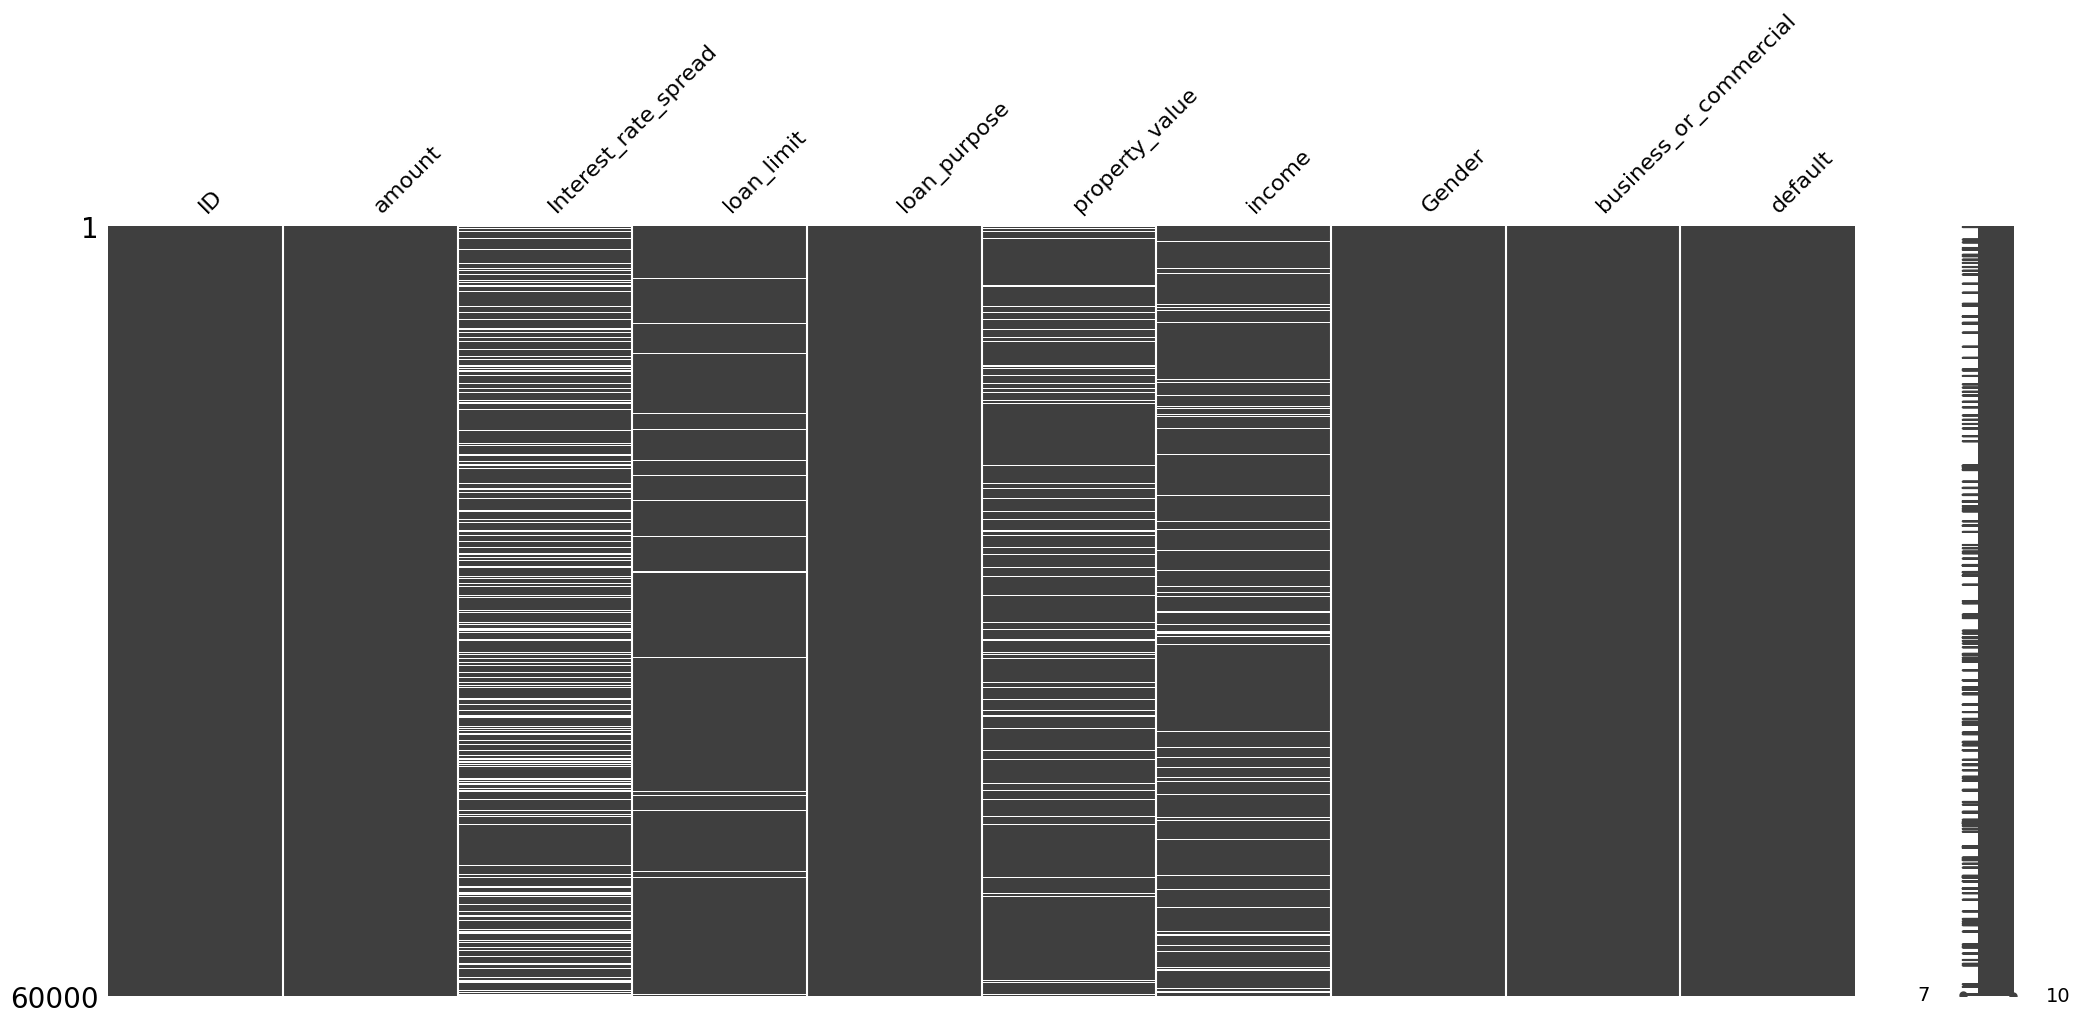

<Figure size 1300x1000 with 0 Axes>

In [47]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(data)
plt.figure(figsize = (13,10))
plt.show()

The white parts are the explicit missing values in the main plots. The bar on the left shows the concentration of missing values in the different rows for the different indicators. It also contains two numbers that show the minimum completeness and the maximum completeness among the rows. Here, the minimun completeness shows that there are some rows that just contain data from 7 columns and the rest are missing.

## 2- Handling the missing values

Here we discuss a popular and effective method to handle missing values. The simplest approach of handling the missing values is to remove the rows that have missing values completely. We do not take this approach as it results in losing the information that exists in the non-missing cells of those rows.

To implement our approach, we firstly focus on the numerical indicators. We separate them first.

In [48]:
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
numerical_data = data[numerical_columns]
numerical_data.isnull().sum()

ID                          0
amount                      0
Interest_rate_spread    14792
property_value           6144
income                   3721
default                     0
dtype: int64

As we see, there are 3 indicators with missing values among the numerical columns. To fill those missing cells, we use K Nearest Neighbor imputer. This method looks for a set of other rows (neighbors) that have closest values for the non-missing indicators to our target row. After finding them, it performs an averaging on the inidicator that we miss in our target row in those neighbors. Finally, it fills the missing value of our target row with the average.

More information about KNN Imputer at https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html and https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm.

In our implementation, we use 3 neighbors for imputation. Using more neighbors may provide better results, but it also results in higher runtime

In [49]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
imputed_numerical_data = imputer.fit_transform(numerical_data)

As the output of KNNImputer is not a Pandas dataframe by default, we have to transform it to a dataframe. To do so, we should give the name of the columns to it that we saved before.

In [50]:
imputed_numerical_data = pd.DataFrame(imputed_numerical_data, columns=numerical_columns)

In [51]:
imputed_numerical_data.isnull().sum()

ID                      0
amount                  0
Interest_rate_spread    0
property_value          0
income                  0
default                 0
dtype: int64

In [52]:
imputed_numerical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    60000 non-null  float64
 1   amount                60000 non-null  float64
 2   Interest_rate_spread  60000 non-null  float64
 3   property_value        60000 non-null  float64
 4   income                60000 non-null  float64
 5   default               60000 non-null  float64
dtypes: float64(6)
memory usage: 2.7 MB


As we see, there are no numerical missing values in the output. Let's have a look on the categorical indicators.

In [53]:
categorical_columns = data.select_dtypes(include=['object']).columns
categorical_data = data[categorical_columns]

In [54]:
categorical_data.isnull().sum()

loan_limit                1335
loan_purpose                61
Gender                       0
business_or_commercial       0
dtype: int64

As we see, there are two categorical indicators with 'explicit' missing values. However, it is very common that we have 'implicit' missing values in categorical data as well. These are basically the cells that are not left empty, instead it is written in them that they do not have data; for example, by writing "No data exists" in that cell.

To check for implicit missing values, we print all the unique objects that exist for every categorical indicator.

In [55]:
for i in range(len(categorical_columns)):
    print(categorical_columns[i],data[categorical_columns[i]].unique())

loan_limit ['cf' 'ncf' nan]
loan_purpose ['p3' 'p1' 'no info' 'p2' nan]
Gender ['Non-binary' 'Male' 'Female' 'Sex Not Available']
business_or_commercial ['nob/c' 'b/c']


As we see, we have 'no info' in loan purpose column and 'Sex Not Available' in Gender column that indicate implicit missing values. We use NumPy library to replace them with NaN, which makes them explicit and update our categorical data.

In [56]:
import numpy as np

data['Gender'] = data['Gender'].replace('Sex Not Available', np.nan)
data['loan_purpose'] = data['loan_purpose'].replace('no info', np.nan)

categorical_data = data[categorical_columns]

In [57]:
categorical_data.isnull().sum()

loan_limit                 1335
loan_purpose              22138
Gender                    15075
business_or_commercial        0
dtype: int64

We see that we have 3 categorical indicators with missing values indeed.

To impute these missing values, we use the mode of the relevant columns. As the mode shows the most common category in each of these indicators, it can be a good choice for imputation of null cells.

In [58]:
imputed_categorical_data = categorical_data

for i in categorical_columns:
    mode = categorical_data[i].mode()
    mode = mode[0]
    imputed_categorical_data[i].fillna(value=mode, inplace=True)

<ipython-input-58-6c89b9a0ff6b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_categorical_data[i].fillna(value=mode, inplace=True)
<ipython-input-58-6c89b9a0ff6b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_categorical_data[i].fillna(value=mode, inplace=True)
<ipython-input-58-6c89b9a0ff6b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_categorical_data[i].fillna(value=mode, inplace=True)
<ipython-inpu

In [59]:
imputed_categorical_data.isnull().sum()

loan_limit                0
loan_purpose              0
Gender                    0
business_or_commercial    0
dtype: int64

In [60]:
imputed_categorical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   loan_limit              60000 non-null  object
 1   loan_purpose            60000 non-null  object
 2   Gender                  60000 non-null  object
 3   business_or_commercial  60000 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


Now as we handeled the missing data in numerical indicators and categorical indicators, we concatinate them and perform final checking.

In [61]:
imputed_data = pd.concat([imputed_categorical_data, imputed_numerical_data], axis=1, join='inner')

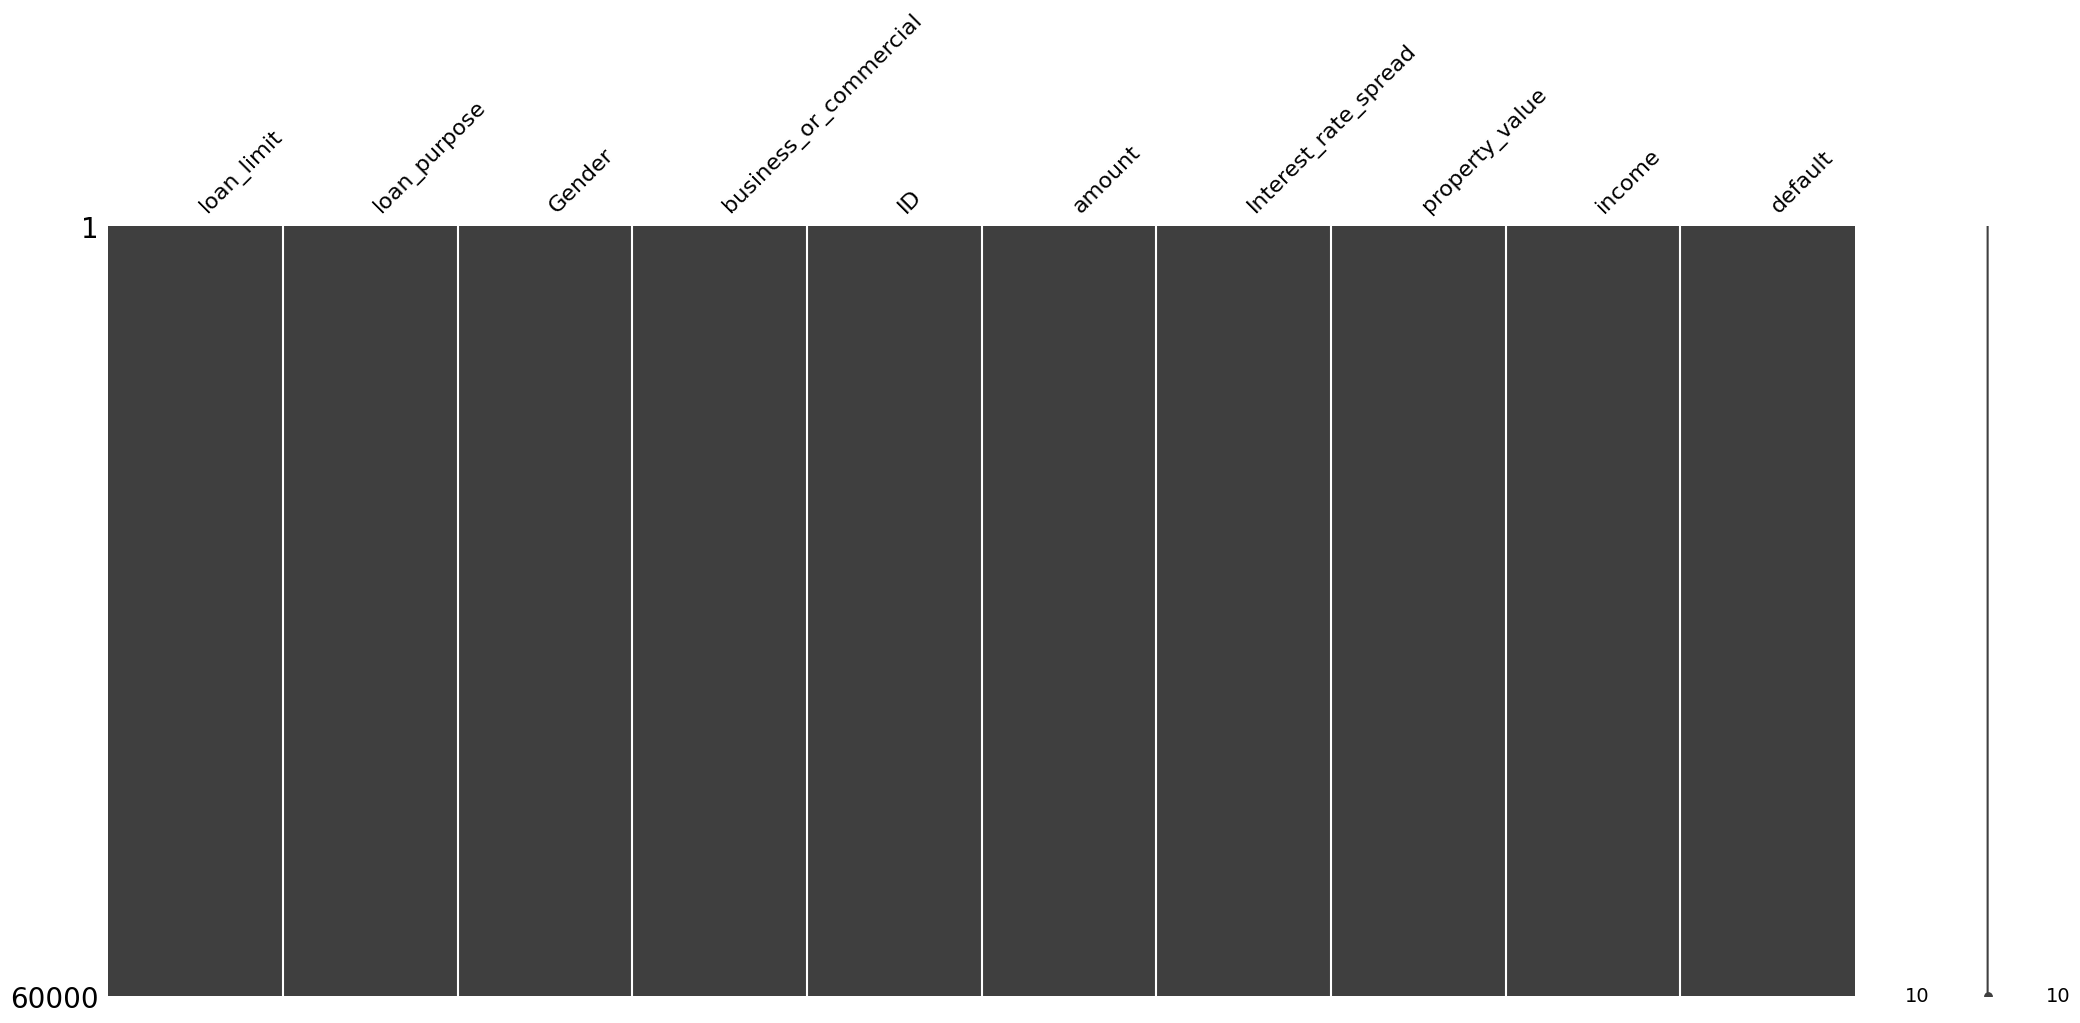

<Figure size 1300x1000 with 0 Axes>

In [62]:
msno.matrix(imputed_data)
plt.figure(figsize = (13,10))
plt.show()

In [63]:
imputed_data.head()

,loan_limit,loan_purpose,Gender,business_or_commercial,ID,amount,Interest_rate_spread,property_value,income,default
0,cf,p3,Non-binary,nob/c,127451.0,266500.0,0.666400,5.180000e+05,5760.0,0.0
1,cf,p1,Male,b/c,47873.0,456500.0,0.825500,4.780000e+05,4920.0,0.0
2,cf,p3,Male,b/c,143258.0,216500.0,0.906033,2.180000e+05,2460.0,1.0
3,ncf,p1,Non-binary,nob/c,82415.0,856500.0,0.300700,1.108000e+06,12360.0,0.0
4,ncf,p3,Male,nob/c,146580.0,116500.0,0.592500,3.446667e+05,4860.0,1.0


## 3- Preprocessing and fitting a model

We cleaned the data so far and in order to implement a predictor model on it, we have to encode the string values in categorical indicators to numerical values, as we saw in the first exercise. Since there are many categorical indicators with different string values in this dataset, this time we use an automatic method to encode them. It is called One Hot Encoding and we implement it using Pandas. More info about one hot encoding at https://en.wikipedia.org/wiki/One-hot and https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html  .

In [64]:
imputed_encoded_categorical_data = pd.get_dummies(imputed_categorical_data)

Here we show a few lines of the one hot encoded data. As we see, since we have 10 unique string objects in our 4 categorical columns (look at the unique objects that we printed before), it makes 10 columns and fill them with 1 when they have that specific object.

In [65]:
imputed_encoded_categorical_data.head()

,loan_limit_cf,loan_limit_ncf,loan_purpose_p1,loan_purpose_p2,loan_purpose_p3,Gender_Female,Gender_Male,Gender_Non-binary,business_or_commercial_b/c,business_or_commercial_nob/c
0,1,0,0,0,1,0,0,1,0,1
1,1,0,1,0,0,0,1,0,1,0
2,1,0,0,0,1,0,1,0,1,0
3,0,1,1,0,0,0,0,1,0,1
4,0,1,0,0,1,0,1,0,0,1


Afterwards, we concatenate the encoded categorical data with numerical data.

In [66]:
imputed_data = pd.concat([imputed_encoded_categorical_data, imputed_numerical_data], axis=1, join='inner')

In [67]:
imputed_data.head()

,loan_limit_cf,loan_limit_ncf,loan_purpose_p1,loan_purpose_p2,loan_purpose_p3,Gender_Female,Gender_Male,Gender_Non-binary,business_or_commercial_b/c,business_or_commercial_nob/c,ID,amount,Interest_rate_spread,property_value,income,default
0,1,0,0,0,1,0,0,1,0,1,127451.0,266500.0,0.666400,5.180000e+05,5760.0,0.0
1,1,0,1,0,0,0,1,0,1,0,47873.0,456500.0,0.825500,4.780000e+05,4920.0,0.0
2,1,0,0,0,1,0,1,0,1,0,143258.0,216500.0,0.906033,2.180000e+05,2460.0,1.0
3,0,1,1,0,0,0,0,1,0,1,82415.0,856500.0,0.300700,1.108000e+06,12360.0,0.0
4,0,1,0,0,1,0,1,0,0,1,146580.0,116500.0,0.592500,3.446667e+05,4860.0,1.0


Since we do not have two separated datasets for training and testing in this exercise, we have to divide it. We divide the dataset by train_test_split function from Scikitlearn. More info at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html .

The output of this dataset is default. Whether a user has a loan default or not.

In [68]:
from sklearn.model_selection import train_test_split

imputed_data.columns = imputed_data.columns.astype(str)

train_set, test_set = train_test_split(imputed_data, test_size=0.2, random_state=8)

y_train = train_set['default']
X_train = train_set.drop(columns=['default'])
y_test = test_set['default']
X_test = test_set.drop(columns=['default'])

We fit a Decision Tree Classifier and a Random Forest Classifier on training set and test them on testing set.

In [69]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()
model_rf.fit(X=X_train, y=y_train);

model_dt = DecisionTreeClassifier()
model_dt.fit(X=X_train, y=y_train);

In [70]:
model_dt.score(X=X_test, y=y_test)

0.68875

In [71]:
model_rf.score(X=X_test, y=y_test)

0.7743333333333333

We see that our Random Forest Classifier provides a better accuracy than the deicision tree classifier. However, the 'score' function uses a default 0.5 confidence threshold for evaluation and it does not help us to check the effectiveness of our model in other confidence threshold in case we need a more conservative or permissive model.

## 4- Evaluating of the effectiveness of the model in different confidence thresholds

To evaluate a model for different thresholds, we need to manually output the probabilities that our models produce for classification of every user.

In [72]:
model_rf_probs = model_rf.predict_proba(X_test)

model_rf_probs = model_rf_probs[:, 1]

In [73]:
model_dt_probs = model_dt.predict_proba(X_test)

model_dt_probs = model_dt_probs[:, 1]

Now that we have the probabilites, we can plot the ROC curves that show us the True Positive Rate vs. False Positive Rate of a model, when we change the confidence threshold.

<ipython-input-74-6acab5b0e046>:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  plt.plot(model_dt_fpr, model_dt_tpr, 's', marker='o',color='darkorange', label='Decision Tree Classifier')


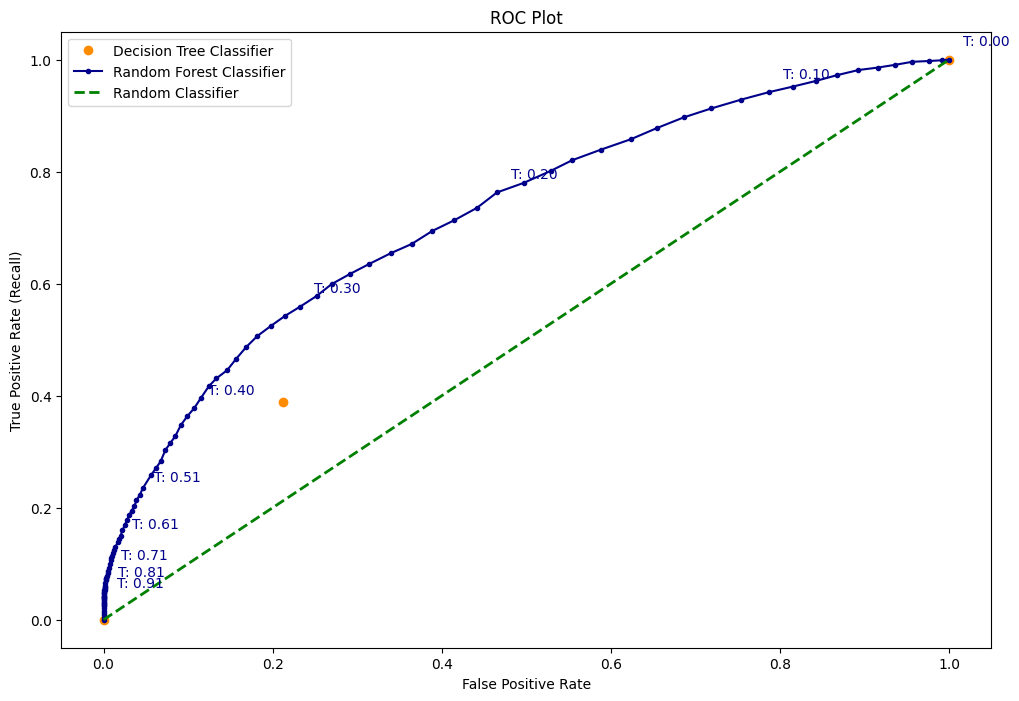

In [74]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

model_dt_fpr, model_dt_tpr, _ = roc_curve(y_test, model_dt_probs)
model_rf_fpr, model_rf_tpr, model_rf_thresholds = roc_curve(y_test, model_rf_probs)

plt.figure(figsize=(12, 8))
plt.plot(model_dt_fpr, model_dt_tpr, 's', marker='o',color='darkorange', label='Decision Tree Classifier')
plt.plot(model_rf_fpr, model_rf_tpr, marker='.',color='darkblue', label='Random Forest Classifier')
for i in range(0, len(model_rf_thresholds), len(model_rf_thresholds)//10):
    if 1>=model_rf_thresholds[i]>=0:
      plt.annotate(f'T: {model_rf_thresholds[i]:.2f}', (model_rf_fpr[i], model_rf_tpr[i]),color='darkblue', textcoords="offset points", xytext=(10,10), ha='left')
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--', label='Random Classifier')


plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.show()

In this plot, the left side show a more conservative model that produces less false positive predictions with the cost of less true positive predictions and the right side shows a more permissive model that produces more true positive predictions with the cost of more false positive predictions.

The dashed green line shows a completely random classifier that always produce the same rate of true positive and false positive.

The orange dots show the decision tree classifier. As decision tree is a discrete classifier that only outputs a class label (either 1 or 0 for with loan default and without loan default in this case), changing the confidance threshold between 0 and 1 does not change the result and the result is always the orange dot in the center. However, as random forest is an ranking classifier that its result is made voting of an ensemble of decision tress, by changing the confidence threshold we can have access to different true positive rates and false positive rates. For all the models, when the threshold reaches 0 and less than 0, the true positive rate and false positive rates both reach 1, that means the model just predicts that every one has a lone loan default. On the other side, when the probablity threshold reaches 1 and beyond 1, it means that the models predict that nobody has a loan default.

The models that are closer to the top-left point are stronger as they can provide more true positive predicition without having many false positive predicitions.

To have access to different classification thresholds, we can set it manually instead of using 'score' function. We then show the accuracy using the 'classification report' function that we learned in Exercise 1. We do this for the Random Forest Classifier

In [75]:
from sklearn.metrics import classification_report

threshold = 0.5
predicted_classes = (model_rf_probs >= threshold).astype(int)
print(classification_report(y_test, predicted_classes))

              precision    recall  f1-score   support

         0.0       0.79      0.95      0.86      9013
         1.0       0.63      0.23      0.34      2987

    accuracy                           0.77     12000
   macro avg       0.71      0.59      0.60     12000
weighted avg       0.75      0.77      0.73     12000



As we see, when the threshold is equal to 0.5, the accuracy is the same as 'score' function output, since 'score' uses the same threshold. To check the true positive rate and false positive rate of a model with this threshold, we use confusion matrix. More info about confusion matrix at https://en.wikipedia.org/wiki/Confusion_matrix

In [76]:
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(y_test, predicted_classes)

print(CM)

[[8595  418]
 [2286  701]]


In [77]:
TN, FP, FN, TP = CM.ravel()

TPR = TP / (TP + FN)

print("True Positive Rate:", TPR)

FPR = FP / (FP + TN)

print("False Positive Rate:", FPR)

True Positive Rate: 0.23468362905925677
False Positive Rate: 0.046377454787529124


In order to have a more permissive model that provides a higher rate of true positives, we can set a lower threshold. The opposite can be done if we need a more conservative threshold. We set the threshold equal to 0.1 .

In [78]:
threshold = 0.1

predicted_classes = (model_rf_probs >= threshold).astype(int)

print(classification_report(y_test, predicted_classes))

              precision    recall  f1-score   support

         0.0       0.92      0.21      0.35      9013
         1.0       0.28      0.94      0.44      2987

    accuracy                           0.39     12000
   macro avg       0.60      0.58      0.39     12000
weighted avg       0.76      0.39      0.37     12000



In [79]:
CM = confusion_matrix(y_test, predicted_classes)

print(CM)

[[1920 7093]
 [ 173 2814]]


In [80]:
TN, FP, FN, TP = CM.ravel()

TPR = TP / (TP + FN)

print("True Positive Rate:", TPR)

FPR = FP / (FP + TN)

print("False Positive Rate:", FPR)

True Positive Rate: 0.9420823568798126
False Positive Rate: 0.7869743703539333


We see that using this permissive threshold, we can have higher number of true positive classifications. This comes with a cost of higher false positive rate.

The opposite can be done if we need a more conservative threshold.

In [81]:
threshold = 0.9

predicted_classes = (model_rf_probs >= threshold).astype(int)

print(classification_report(y_test, predicted_classes))

              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86      9013
         1.0       0.99      0.04      0.07      2987

    accuracy                           0.76     12000
   macro avg       0.87      0.52      0.47     12000
weighted avg       0.82      0.76      0.66     12000



In [82]:
CM = confusion_matrix(y_test, predicted_classes)

print(CM)

[[9012    1]
 [2880  107]]


In [83]:
TN, FP, FN, TP = CM.ravel()

TPR = TP / (TP + FN)

print("True Positive Rate:", TPR)

FPR = FP / (FP + TN)

print("False Positive Rate:", FPR)

True Positive Rate: 0.035821894877803816
False Positive Rate: 0.00011095084877399312


Finally, we can have access to 'area under curve (AUC)' of our random forest model for the ROC plot using Scikit Learn. It is a powerfull indicator that shows the effectiveness of a model for different confidence thresholds and it can be used as an effective tool for comparison of models. More info at https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

In [84]:
from sklearn.metrics import roc_auc_score

model_rf_auc = roc_auc_score(y_test, model_rf_probs)

print( model_rf_auc)

0.7245983194828018
